# Examining the choice of training set size and the exclusion/inclusion of ISO group 7 ("flawed") spectra

In [36]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from concurrent.futures import ProcessPoolExecutor
from IPython.core.debugger import set_trace as st
from sklearn.model_selection import train_test_split
from time import time

# My modules
from swsnet import helpers

print(tf.__version__)

1.10.0


In [37]:
# def run_NN(features, labels, test_size):
def run_NN(input_tuple):
    """Run a Keras NN for the purpose of examining the effect of training set size.
    
    Args:
        features (ndarray): Array containing the spectra (fluxes).
        labels (ndarray): Array containing the group labels for the spectra.
        test_size (float): Fraction of test size relative to (test + training).
        
    Returns:
        test_size (float): Input test_size, just a sanity check!
        accuracy (float): Accuracy of this neural net when applied to the test set.
    """
    
    features, labels, test_size = input_tuple
    
    X_train, X_test, y_train, y_test = \
        train_test_split(features, labels, test_size=test_size, random_state = 42)
    
    # Sequential model, 7 classes of output.
    model = keras.Sequential()
    model.add(keras.layers.Dense(64, activation='relu', input_dim=359))
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dense(7, activation='softmax'))

    # Early stopping condition.
    callback = [tf.keras.callbacks.EarlyStopping(monitor='acc', patience=3, verbose=0)]

    # Recompile model and fit.
    model.compile(optimizer=tf.train.AdamOptimizer(0.0005),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
#     model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=False)
    model.fit(X_train, y_train, epochs=50, batch_size=32, callbacks=callback, verbose=False)

#     # Summary
#     model.summary()

    # Check accuracy.
    score = model.evaluate(X_test, y_test, verbose=0)
    accuracy = score[1]
#     print('Test loss:', score[0])
#     print('Test accuracy:', score[1])

    return test_size, accuracy

## Dataset: ISO-SWS

In [38]:
# Needed directories
base_dir = '../data/isosws_atlas/'

# Pickles containing our spectra in the form of pandas dataframes:
spec_dir = base_dir + 'spectra/'
spec_files = np.sort(glob.glob(spec_dir + '*.pkl'))

# Metadata pickle (pd.dataframe). Note each entry contains a pointer to the corresponding spectrum pickle.
metadata = base_dir + 'metadata.pkl'

#### Labels ('group'):

1. Naked stars
2. Stars with dust
3. Warm, dusty objects
4. Cool, dusty objects
5. Very red objects
6. Continuum-free objects but having emission lines
7. Flux-free and/or fatally flawed spectra

N.B., these are shifted down by 1 in the labels (to span 0-6) for the model.

### Subset 1: all data included

In [39]:
features, labels = helpers.load_data(base_dir=base_dir, metadata=metadata, clean=False, verbose=False)

In [40]:
print(features.shape)
print(labels.shape)

(1235, 359)
(1235,)


### Subset 2: exclude group=7 data

In [41]:
features_clean, labels_clean = helpers.load_data(base_dir=base_dir, metadata=metadata, clean=True, verbose=False)

In [42]:
print(features_clean.shape)
print(labels_clean.shape)

(1058, 359)
(1058,)


# Model 1. Neural network

In [79]:
# Values of test_size to probe.
search_space = np.arange(0.04, 0.62, 0.02)
print('Size of test set considered: ', search_space)

# Number of iterations for each test_size value.
n_iterations = 20

# Create a vector to iterate over.
rx = np.array([search_space] * n_iterations).T
search_space_full = rx.flatten()

print('Number of iterations per test_size: ', n_iterations)
print('Total number of NN iterations required: ', n_iterations * len(search_space))

Size of test set considered:  [0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26 0.28 0.3
 0.32 0.34 0.36 0.38 0.4  0.42 0.44 0.46 0.48 0.5  0.52 0.54 0.56 0.58
 0.6 ]
Number of iterations per test_size:  20
Total number of NN iterations required:  580


In [80]:
# Wrap up tuple inputs for running in parallel.
search_map = [(features, labels, x) for x in search_space_full]
search_map_clean = [(features_clean, labels_clean, x) for x in search_space_full]

### Training set size vs. accuracy (with group 7)

In [81]:
# Run the networks in parallel.
start = time()
pool = ProcessPoolExecutor(max_workers=14)
results = list(pool.map(run_NN, search_map))
end = time()
print('Took %.3f seconds' % (end - start))

run_matrix = np.array(results)

Took 268.404 seconds


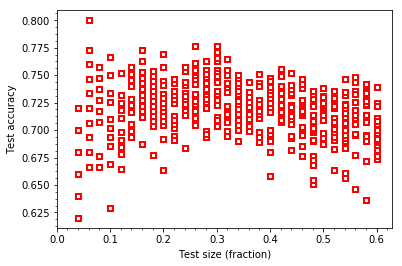

In [82]:
# Examine results.
plt.plot(run_matrix.T[0], run_matrix.T[1], 's', mfc='w', ms=5, mew=2, mec='r');
plt.xlabel('Test size (fraction)');
plt.ylabel('Test accuracy');
plt.minorticks_on();
plt.xlim(xmin=0);

### Training set size vs. accuracy (without group 7)

In [83]:
# Run the networks in parallel.
start = time()
pool = ProcessPoolExecutor(max_workers=16)
results_clean = list(pool.map(run_NN, search_map_clean))
end = time()
print('Took %.3f seconds' % (end - start))

run_matrix_clean = np.array(results_clean)

Took 221.896 seconds


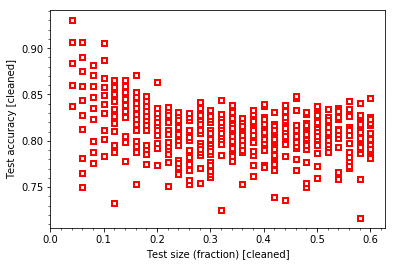

In [84]:
# Examine results.
plt.plot(run_matrix_clean.T[0], run_matrix_clean.T[1], 's', mfc='w', ms=5, mew=2, mec='r');
plt.xlabel('Test size (fraction) [cleaned]');
plt.ylabel('Test accuracy [cleaned]');
plt.minorticks_on();
plt.xlim(xmin=0);